# <img src="./assets/logo_infnetv1.png" alt="Infnet logo" height="45"/> Projeto de Disciplina de Validação de Modelos de Clusterização
<img src="https://img.shields.io/badge/python-v._3.11.5-blue?style=flat-square&logo=python&logoColor=white" alt="python_logo" height="20"/>
<img src="https://img.shields.io/badge/jupyter-v._5.7.2-blue?style=flat-square&logo=jupyter&logoColor=white" alt="jupyter_logo" height="20"/>
<img src="https://img.shields.io/badge/anaconda-v._23.7.4-blue?style=flat-square&logo=anaconda&logoColor=white" alt="anaconda_logo" height="20"/>

#### Aluno: Mateus Teixeira Ramos da Silva

### Índice

---

- <a href='#parte-1-infraestrutura'>Parte 1. Infraestrutura</a>

- <a href='#parte-2-escolha-de-base-de-dados'>Parte 2. Escolha de base de dados</a>

- <a href='#parte-3-clusterização'>Parte 3. Clusterização</a>

- <a href='#parte-4-medidas-de-similaridade'>Parte 4. Medidas de similaridade</a>

## Importar os pacotes

---


In [215]:
# Importar os pacotes

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pkg_resources
import seaborn as sns
import subprocess
import sys

from datetime import datetime
from ds_utils.unsupervised import plot_cluster_cardinality
from matplotlib import cm
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import euclidean
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [59]:
#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install matplotlib
#!pip install scipy
#!pip install scikit-learn
#!pip install data-science-utils

## Parte 1. Infraestrutura

---

<a href='#índice'>Voltar ao início</a>

### 1.1. Você está rodando em Python 3.9+

In [60]:
print("Versão do Python utilizada:", sys.version)

Versão do Python utilizada: 3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]


### 1.2. Você está usando um ambiente virtual: Virtualenv ou Anaconda

In [61]:
print("Ambiente virtual:", os.getenv("CONDA_DEFAULT_ENV"))

Ambiente virtual: venv_validacao


### 1.3. Todas as bibliotecas usadas nesse exercício estão instaladas em um ambiente virtual específico

Resposta:

Requisito atendido no arquivo ‘requirements.txt’, presente no repositório (https://github.com/GitMateusTeixeira/ml_clustering/tree/main/infnet_validation_pd).

### 1.4. Gere um arquivo de requerimentos (requirements.txt) com os pacotes necessários. É necessário se certificar que a versão do pacote está disponibilizada.

Resposta:

Requisito atendido no arquivo ‘requirements.txt’, presente no repositório (https://github.com/GitMateusTeixeira/ml_clustering/tree/main/infnet_validation_pd).


In [231]:
!pip freeze > requirements.txt

## Parte 2. Escolha de base de dados

---

<a href='#índice'>Voltar ao início</a>

### 2.1. Escolha uma base de dados para realizar o trabalho. Essa base será usada em um problema de clusterização.

Resposta:

Foi escolhida uma base de dados sobre transações bancárias realizadas em um banco Indiano, com as seguintes informações:

- id_transacao (TransactionID): Id da transferência feita
- id_cliente (CustomerID): Id do cliente
- idade_calculada (CustomerDOB): Idade do cliente no período da transferência
- genero (CustGender): Gênero sexual do cliente
- localizazao (CustLocation): Localização do cliente
- saldo (CustAccountBalance): Saldo da conta do cliente após a transferência
- data_transacao (TransactionDate): Data da transferência
- hora_transacao (TransactionTime): Hora da transferência em timestamp Unix (o número de segundos que se passaram desde a data da coluna anterior)
- quantia_transacao (INR) (TransactionAmount (INR)): Valor da transferência em rúpias indianas (INR)

In [62]:
caminho = 'data\\'
arquivo = 'bank_transactions_clean_data' + '.csv'
# Caminho completo para o novo arquivo
caminho_arquivo = os.path.join(caminho, arquivo)

dados = pd.read_csv(caminho_arquivo, encoding='latin-1', on_bad_lines='skip', sep=',')

In [63]:
dados.shape

(15729, 11)

In [64]:
# Selecionando as colunas utilizadas
dados = dados[['id_cliente', 'idade_calculada', 'genero', 'localizacao', 'saldo', 'quantia_transacao (INR)']]

In [65]:
# Detalhando a base de dados com moda
def check(df):
    l = []
    colunas = df.columns
    
    for col in colunas:
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        sum_null = df[col].isnull().sum()

        # Calcula a moda e a frequência da moda
        moda = df[col].mode().iloc[0] if not df[col].mode().empty else "Não se aplica"
        moda_freq = df[col].value_counts().iloc[0] if not df[col].value_counts().empty else "Não se aplica"

        if np.issubdtype(dtypes, np.number):
            status = df.describe(include='all').T
            media = status.loc[col, 'mean']
            std = status.loc[col, 'std']
            min_val = status.loc[col, 'min']
            quar1 = status.loc[col, '25%']
            mediana = df[col].median()
            quar3 = status.loc[col, '75%']
            max_val = status.loc[col, 'max']
                    
        else:
            status = "Não se aplica"
            media = "Não se aplica"
            std = "Não se aplica"
            min_val = "Não se aplica"
            quar1 = "Não se aplica"
            mediana = "Não se aplica"
            quar3 = "Não se aplica"
            max_val = "Não se aplica"

        l.append([col, dtypes, nunique, sum_null, media, std, min_val, quar1, mediana, quar3, max_val, moda, moda_freq])
    
    # Criação do DataFrame com as novas colunas
    df_check = pd.DataFrame(l)
    df_check.columns = ['coluna', 'tipo', 'únicos', 'null_soma', 'media', 'desvio', 
                        'minimo', '25%', 'mediana', '75%', 'maximo', 'moda', 'frequência_moda']
    
    return df_check 

check(dados)

,coluna,tipo,únicos,null_soma,media,desvio,minimo,25%,mediana,75%,maximo,moda,frequência_moda
0,id_cliente,object,15693,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,C1028915,2
1,idade_calculada,int64,70,0,30.708309,8.498054,12.0,25.0,29.0,34.0,84.0,31,1584
2,genero,object,2,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,M,11589
3,localizacao,object,1644,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,MUMBAI,1571
4,saldo,float64,13997,0,104331.201033,457364.148862,0.0,4698.99,16609.17,56051.97,17772978.13,0.0,46
5,quantia_transacao (INR),float64,4584,0,1649.588309,8419.478006,0.0,169.0,452.0,1189.0,569500.27,100.0,518


In [66]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15729 entries, 0 to 15728
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               15729 non-null  object 
 1   idade_calculada          15729 non-null  int64  
 2   genero                   15729 non-null  object 
 3   localizacao              15729 non-null  object 
 4   saldo                    15729 non-null  float64
 5   quantia_transacao (INR)  15729 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 737.4+ KB


Transformando a coluna 'idade' de data para uma idade

In [67]:
dados.sample(3)

,id_cliente,idade_calculada,genero,localizacao,saldo,quantia_transacao (INR)
7827,C8033443,24,M,AGRA,357750.87,12.0
2311,C4327213,24,M,PANCHKULA,6676.70,400.0
3734,C6675058,27,F,HYDERABAD,1033.37,1000.0


### 2.2. Escreva a justificativa para a escolha de dados, dando sua motivação e objetivos.

Resposta:

Foi escolhida uma base de dados que simulam mais de 50 mil transações de clientes feitas em um banco indiano. Essa base foi escolhida pois simula bem um problema da vida real, com um dataset cheio de dados nulos, que precisam de um tratamento prévio, dando um aspecto mais orgânico para a clusterização.

O objetivo é traçar o perfil preponderante dos clientes, através da clusterização das transações realizadas.

### 2.3. Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

Resposta:

A análise gráfica realizada no código demonstra a presença de alguns dados cujo valor se encontra bem distante da maioria (como na coluna 'saldo' e 'quantia_transacao'), o que pode (ou não) representar dados outliers e a necessidade de tratamento dos mesmos.

Embora estejam tratados na pipeline 'tratamento.py', deve-se adaptar as colunas categóricas e padronizar as colunas numéricas para que os dados fiquem compatíveis com os modelos que irão ser utilizados.

A rigor, em razão do dataset apresentar dados de transferências bancárias e haver saldos com valores bem dispares (de 0 a 17 milhões de rúpias indianas), não são valores nulos. Deve-se, portanto, padronizar os dados, de modo que amenize a diferença entre eles, sem, contudo, substituí-los de nenhuma forma (pela média, mediana, ...).

Antes da etapa de clusterização deve-se ainda realizar uma análise exploratória dos dados, a fim de verificar se o dataset possui algum dado nulo, duplicado, incorreto ou ainda incompatível com os modelos de clusterização (vale dizer que esses modelos trabalham com dados numéricos). Tudo no intuito de deixar os dados compatíveis com os modelos que irão ser utilizados.

Para esse dataset em específico, observou-se que a coluna 'saldo' trata-se do saldo que o cliente possuia antes da transferência, assim, se somarmos 'saldo' com 'quantia_transacao' obteremos o **saldo total**. A partir daí, podemos retirar a porcentagem que os clientes transferiram de suas contas e a porcentagem que ficou retida, possibilitando uma análise de quem movimenta mais a conta (transferindo quase seu saldo inteiro e não deixando nada na conta) e quem retem mais o dinheiro (transferindo pouco do saldo total) - que seria o público-alvo para o oferecimento de produtos de investimento, por exemplo.

A conversão em porcentagem permite ainda uma padronização de escalas, pois a coluna 'idade' já se encontra padronizada entre 10 e 85 (anos) enquanto que 'saldo' e 'quantia_transacao' ficaram também entre 0 e 100, possibilitando uma clusterização com qualidade.

A distribuição da faixa dinâmica já denota que a maioria dos clientes possuem entre 20 e 40 anos e retem cerca de 80% a 100% do seu saldo em conta, realizando transferências baixas, a rigor.

#### 2.3.1. Preparar os dados



Normalizar dados numéricos: Para métodos como K-means, normalizar variáveis com escalas muito diferentes (saldo vs. quantia_transacao).

In [68]:
dados.sample(3)

,id_cliente,idade_calculada,genero,localizacao,saldo,quantia_transacao (INR)
2823,C4438075,42,M,VAPI,351966.10,742.00
14742,C4817631,34,F,NOIDA,67519.04,900.00
7108,C6238587,21,M,NEW DELHI,5683.77,414.75


Coluna 'genero'

Será utilizado para fins de vizualização

In [69]:
# Método de label encoder simples
dados['genero_codificado'] = dados['genero'].map({'M': 0, 'F': 1})

Padronizando 'saldo' e 'quantia_transacao'

In [70]:
# Calcular o saldo total
dados['saldo_total'] = dados['saldo'] + dados['quantia_transacao (INR)']

# Calcular a porcentagem transferida, com verificação para 'quantia_transacao (INR) == 0'
dados['porcentagem_tranferida'] = np.where(
                                            dados['quantia_transacao (INR)'] == 0, 
                                            0, 
                                            (dados['quantia_transacao (INR)'] * 100) / dados['saldo_total']
                                            )

# Calcular a porcentagem de saldo retido em conta, com verificação para 'saldo == 0'
dados['porcentagem_retida'] = np.where(
                                        dados['saldo'] == 0, 
                                        0, 
                                        (dados['saldo'] * 100) / dados['saldo_total']
                                        )

In [71]:
check(dados)

,coluna,tipo,únicos,null_soma,media,desvio,minimo,25%,mediana,75%,maximo,moda,frequência_moda
0,id_cliente,object,15693,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,C1028915,2
1,idade_calculada,int64,70,0,30.708309,8.498054,12.0,25.0,29.0,34.0,84.0,31,1584
2,genero,object,2,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,M,11589
3,localizacao,object,1644,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,MUMBAI,1571
4,saldo,float64,13997,0,104331.201033,457364.148862,0.0,4698.99,16609.17,56051.97,17772978.13,0.0,46
5,quantia_transacao (INR),float64,4584,0,1649.588309,8419.478006,0.0,169.0,452.0,1189.0,569500.27,100.0,518
6,genero_codificado,int64,2,0,0.263208,0.440388,0.0,0.0,0.0,1.0,1.0,0,11589
7,saldo_total,float64,15577,0,105980.789343,458027.301652,0.0,5592.28,17834.93,57718.86,17790704.13,1000.0,4
8,porcentagem_tranferida,float64,15552,0,13.318031,24.401673,0.0,0.67039,2.512903,10.833552,100.0,100.0,45
9,porcentagem_retida,float64,15554,0,86.675612,24.411228,0.0,89.163964,97.487097,99.329428,100.0,0.0,46


In [72]:
check(dados[['saldo']])

,coluna,tipo,únicos,null_soma,media,desvio,minimo,25%,mediana,75%,maximo,moda,frequência_moda
0,saldo,float64,13997,0,104331.201033,457364.148862,0.0,4698.99,16609.17,56051.97,17772978.13,0.0,46


##### Por Boxplot

In [73]:
colunas_numericas = dados.columns[[1, 4, 5, 7, 8, 9]]
dados_numericos = dados[colunas_numericas]

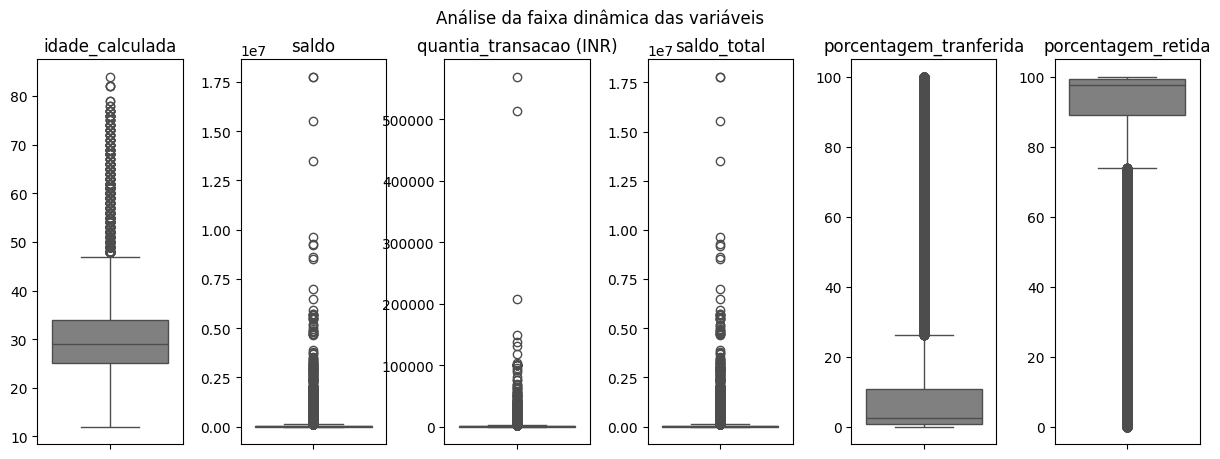

In [74]:
# Configurar o plano de fundo dos gráficos 3 x 3
fundo, eixos = plt.subplots(nrows=1, ncols=6, figsize=(15, 5))
fundo.suptitle("Análise da faixa dinâmica das variáveis")

eixos = eixos.flatten()

# Plotar os gráficos de cada coluna através de um loop
for i, col in enumerate(colunas_numericas):
    sns.boxplot(data=dados, y=col, ax=eixos[i], color='gray')
    eixos[i].set_title(col)
    eixos[i].set_xlabel('')
    eixos[i].set_ylabel('')

# Configurar o espaçamento para não haver sobreposição
plt.subplots_adjust(hspace=0.3, wspace=0.4)

# Exibir o gráfico
plt.show()

##### Por Histplot

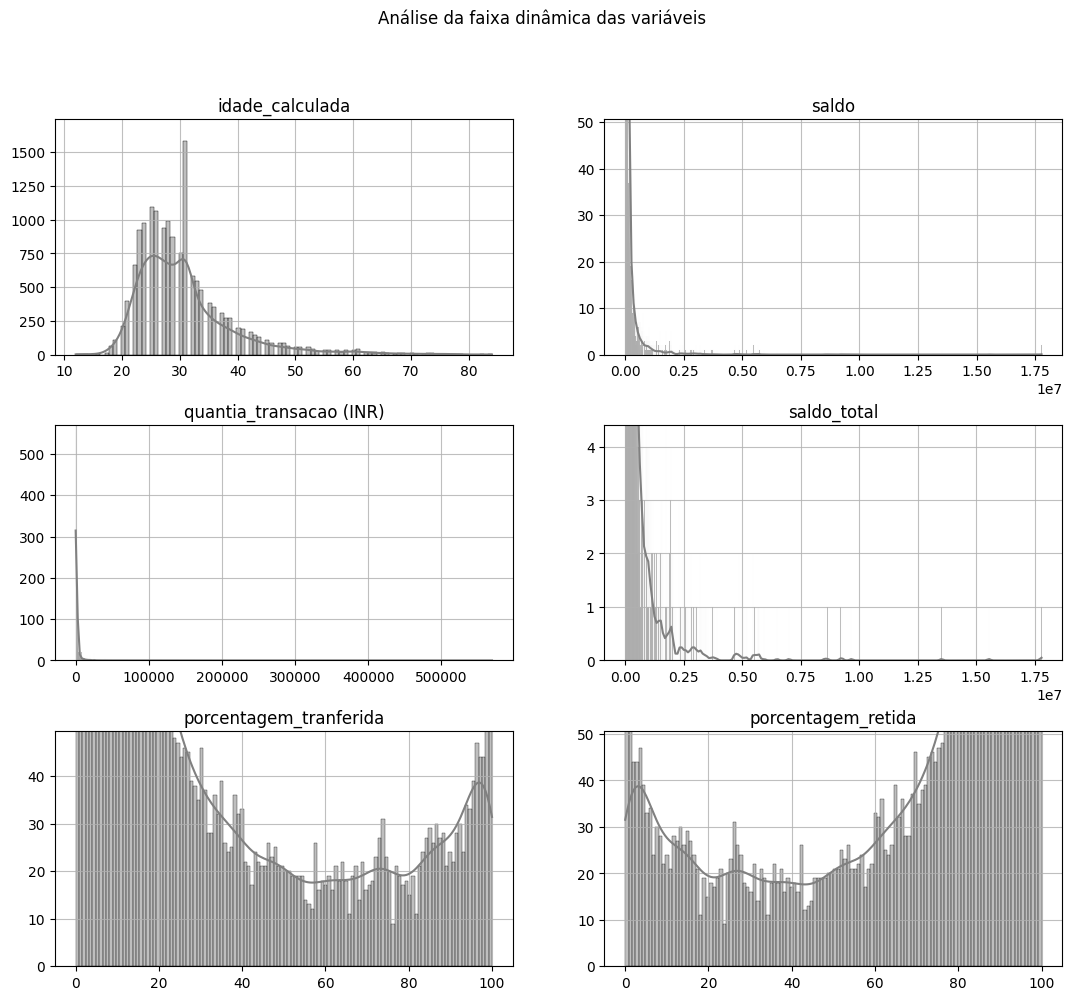

In [76]:
# Configurar o plano de fundo dos gráficos
fundo, eixos = plt.subplots(nrows=3, ncols=2, figsize=(13, 11))
fundo.suptitle("Análise da faixa dinâmica das variáveis")

eixos = eixos.flatten()

# Plotar os gráficos de cada coluna através de um loop
for i, col in enumerate(colunas_numericas):
    sns.histplot(data=dados, x=col, color='gray', kde=True, ax=eixos[i])
    
    # Ajustar os limites do eixo y com base na maior frequência da coluna
    max_y = dados[col].value_counts().max()
    eixos[i].set_ylim(0, max_y + max_y * 0.1)  # Adiciona 10% para espaço visual

    # Configurar título e labels
    eixos[i].set_title(col)
    eixos[i].set_xlabel('')
    eixos[i].set_ylabel('')
    eixos[i].grid(True, alpha=0.8)

# Configurar o espaçamento para não haver sobreposição
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Exibir o gráfico
plt.show()

### 2.4. Realize o pré-processamento adequado dos dados. Descreva os passos necessários.

Resposta:

Analisando os principais métodos de escalonamento e normalização de dados, poderíamos eleger o RobustScaler, pois ele lida bem com outliers, em sua maioria.

Todavia, ao analisar melhor o dataset e perceber que a coluna 'saldo' trata-se da quantia restante após a transferência do valor de 'quantia_transacao' pode-se calcular o saldo total anterior e, assim, determinar, em % o quanto os clientes estão transferindo e retendo em suas contas, que nos auxiliará melhor na análise de perfil.

Essa abordagem - já realizada no ponto 2.3.1. - ainda se iguala na escala da coluna 'idade', deixando padronizadas todas as colunas que serão utilizadas para a clusterização.

Porém, percebeu-se também que a coluna 'porcentagem_transferida' de saldo é o espelho de 'porcentagem_retida', visto que se uma pessoa transfere 40% de seu saldo inicial, ela retem 60%, por isso, essa coluna não será usada na clusterização. Utilizaremos ‘porcenatgem_retida’ e ‘idade’.

Veja-se:

- 'idade': varia de 12 a 84 anos
- 'porcentagem_transferida': varia de 0 a 100 %
- 'porcentagem_retida': varia de 0 a 100 %

In [77]:
check(dados[['idade_calculada', 'porcentagem_tranferida', 'porcentagem_retida']])

,coluna,tipo,únicos,null_soma,media,desvio,minimo,25%,mediana,75%,maximo,moda,frequência_moda
0,idade_calculada,int64,70,0,30.708309,8.498054,12.0,25.000000,29.000000,34.000000,84.0,31.0,1584
1,porcentagem_tranferida,float64,15552,0,13.318031,24.401673,0.0,0.670390,2.512903,10.833552,100.0,100.0,45
2,porcentagem_retida,float64,15554,0,86.675612,24.411228,0.0,89.163964,97.487097,99.329428,100.0,0.0,46


Definir as colunas a serem usadas na clusterização

In [78]:
dados_padronizados = dados[['idade_calculada', 'porcentagem_retida']]

## Parte 3. Clusterização

---

<a href='#índice'>Voltar ao início</a>

### 3.1. Realizar o agrupamento dos dados, escolhendo o número ótimo de clusters. Para tal, use o índice de silhueta e as técnicas:

a. K-Médias

b. DBScan

#### 3.1.a. K-Means

Resposta:

Foi implementado um Grid Search para determinar o número ótimo de ‘k’. Para isso, fora realizado testes no número de ‘k’ (de 2 a 15).

Embora o melhor score da silhueta tenha resultado em ‘k=2’, a seguir, veremos que não é a melhor solução para esse dataset. Isso revela que esses índices são usados para termos um ‘norte’ de como seguir, mas não determina o número específico de clusters.

O modelo foi implementado utilizando ‘k=6’, considerando que o ‘Cluster 3’ (em vermelho) possui dados altamente concentrados, sendo o maior grupo com (9.718 – cerca de 62% da base de dados), porém em um local bem concentrado (em ‘3.1.a.2. Análise gráfica do K-Means’), não indicando a necessidade de mais grupos.

Plotando gráficos isolados de cada cluster - mais abaixo - é possível ver esse fenômeno melhor.


##### 3.1.a.1. Implementando o modelo do K-Means com base nos resultados da silhueta (3.2.)

In [226]:
# Configurar o modelo de clusterização dos dados (K-Means)
n_cluster = 6

kmeans = KMeans(
                algorithm='lloyd',          # algoritmo de análise que vai selecionar a posição inicial dos clusters
                copy_x=True,                # assegura que os dados estarão seguros durante a análise
                init='k-means++',           # método de inicialização da análise
                max_iter=300,               # número máximo de interações em um mesmo ciclo
                n_clusters=n_cluster,       # número de clusters
                n_init='auto',              # número de vezes que o k-means vai rodar com diferentes seeds de centroides
                random_state=12,            # salva uma 'seed' para assegurar reproduções futuras
                tol=0.0001,                 # nível de tolerância de movimentação dos dados para declarar a convergência
                verbose=0                   # controla a quantidade de informações de log que o algoritmo imprime durante sua execução na hora do predict
                )

# Ajustar as configurações do modelo nos dados padronizados
kmeans.fit(dados_padronizados)

# Atribuir novos dados aos clusters existentes
dados['clusters'] = kmeans.predict(dados_padronizados)

##### 3.1.a.2. Análise gráfica do K-Means

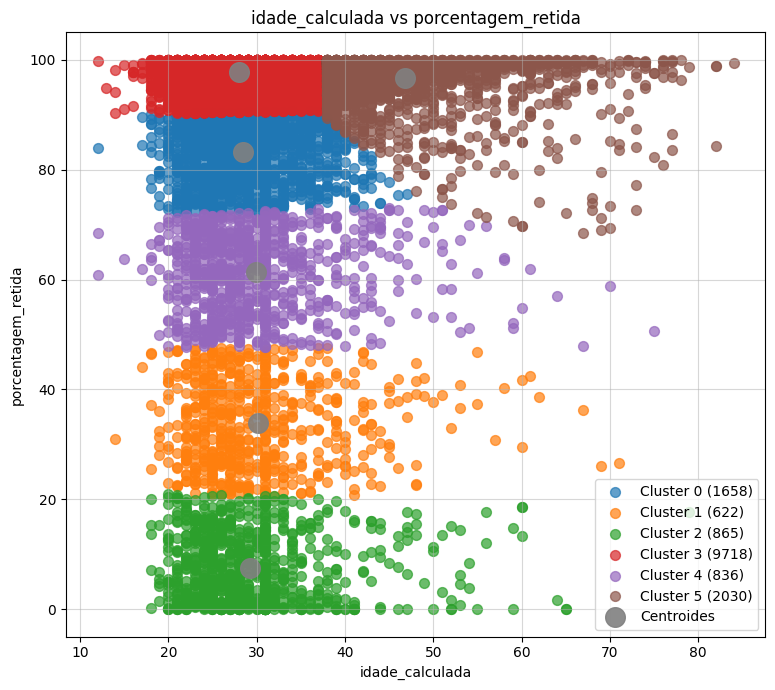

In [227]:
# Colunas para análise
colunas = ['idade_calculada', 'porcentagem_retida']

# Gerar combinações de pares de colunas
combinacoes = list(itertools.combinations(colunas, 2))

# Número de combinações
num_combinacoes = len(combinacoes)

# Configurar subplots (2 colunas por linha, ajustando número de linhas automaticamente)
num_colunas_subplot = 2
num_linhas_subplot = (num_combinacoes + num_colunas_subplot - 1) // num_colunas_subplot

fig, axs = plt.subplots(num_linhas_subplot, num_colunas_subplot, figsize=(15, 7 * num_linhas_subplot))
axs = axs.flatten()  # Achatar a matriz de subplots para iterar facilmente

# Contar o número de indivíduos em cada cluster
cluster_counts = dados['clusters'].value_counts()

# Criar paleta de cores
cores = plt.cm.tab10.colors  # Paleta de cores Tab10 do matplotlib

# Plotar cada combinação em um subplot
for i, (col_x, col_y) in enumerate(combinacoes):
    ax = axs[i]
    for cluster_num in range(n_cluster):  # Número de clusters
        cluster_data = dados[dados['clusters'] == cluster_num]  # Filtrar linhas do cluster atual
        num_individuos = cluster_counts.get(cluster_num, 0)  # Obter número de indivíduos no cluster
        
        ax.scatter(
            cluster_data[col_x],  # Selecionar coluna eixo x
            cluster_data[col_y],  # Selecionar coluna eixo y
            label=f"Cluster {cluster_num} ({num_individuos})",
            s=50,
            alpha=0.7,
            color=cores[cluster_num]  # Aplicar cor específica do cluster
        )

    # Plotar os centroides
    centro_kmeans = kmeans.cluster_centers_
    ax.scatter(
        centro_kmeans[:, colunas.index(col_x)], 
        centro_kmeans[:, colunas.index(col_y)], 
        label='Centroides',
        color='gray', 
        s=200, 
        alpha=0.9
    )

    # Configurações do gráfico
    ax.set_title(f"{col_x} vs {col_y}")
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.grid(visible=True, alpha=0.5)
    
    # Personalizar a legenda com fundo
    ax.legend(loc='best')
    
# Remover subplots vazios
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()

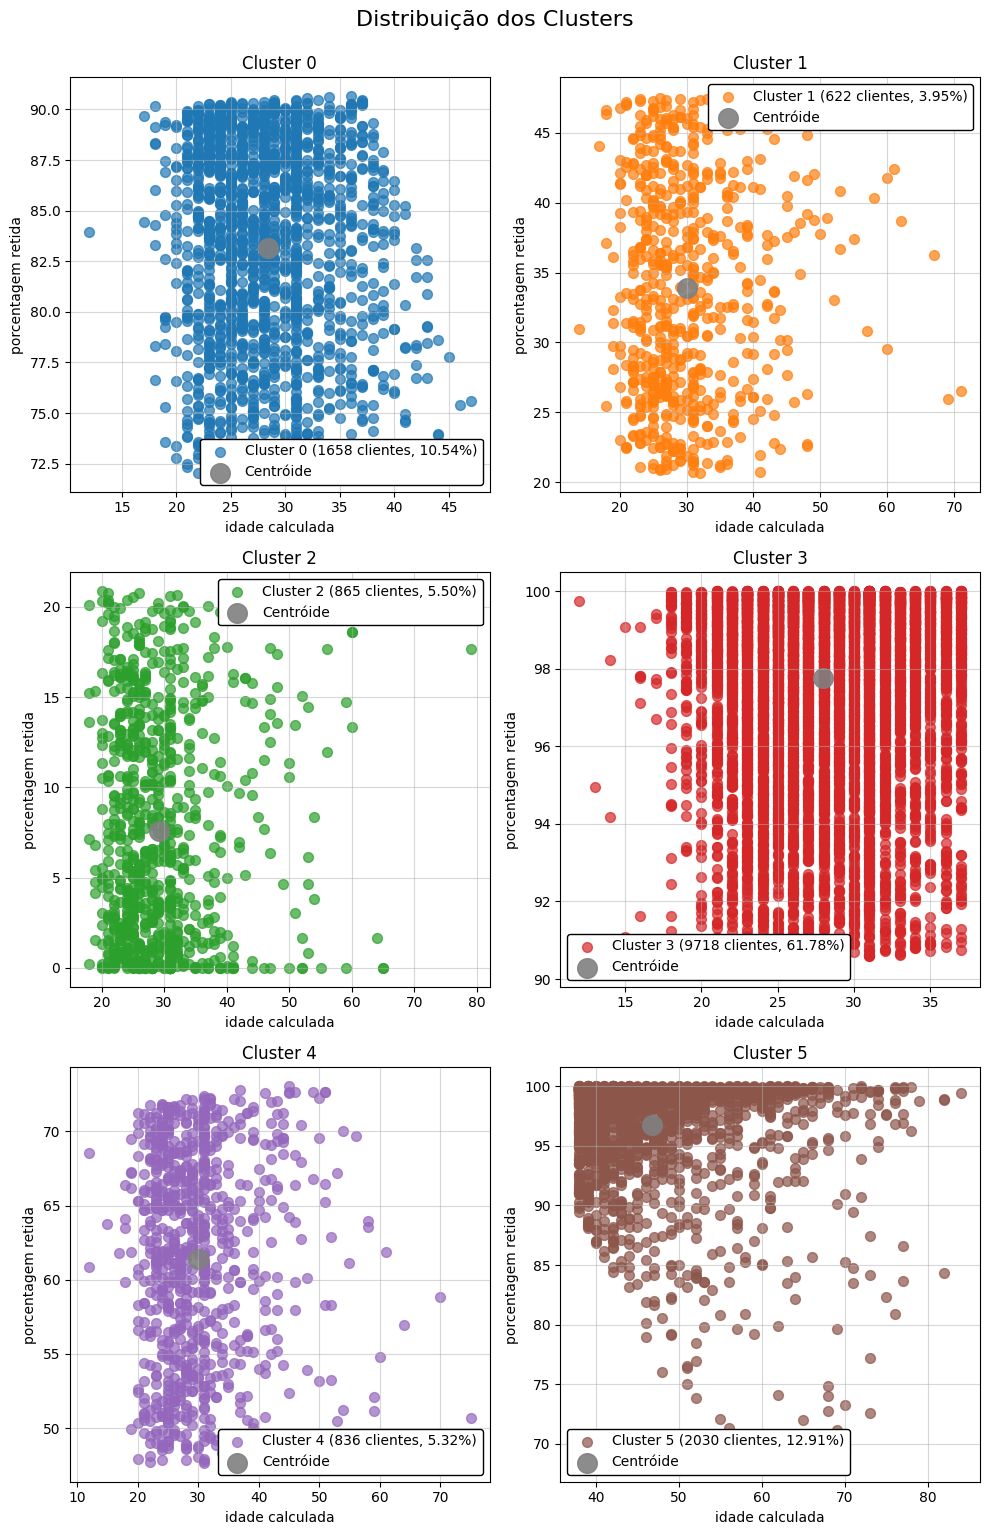

In [83]:
# Criar paleta de cores
cores = plt.cm.tab10.colors  # Paleta de cores Tab10 do matplotlib

def plot_por_cluster(dados, colunas, n_cluster, kmeans):
    """
    Plota uma grade de gráficos distribuídos para cada cluster, destacando apenas o centroide do cluster atual.
    
    Parâmetros:
        dados (pd.DataFrame): Base de dados contendo os clusters.
        colunas (list): Lista de colunas a serem analisadas.
        n_cluster (int): Número de clusters.
        kmeans (KMeans): Objeto KMeans treinado para obter os centroides.
    """
    # Gerar combinações de pares de colunas
    combinacoes = list(itertools.combinations(colunas, 2))
    num_combinacoes = len(combinacoes)
    
    # Configurar a grade de subplots
    num_colunas_grade = 2  # Ajuste este valor para mais ou menos colunas
    num_linhas_grade = (n_cluster + num_colunas_grade - 1) // num_colunas_grade
    
    fig, axs = plt.subplots(num_linhas_grade, num_colunas_grade, figsize=(10, 5 * num_linhas_grade))
    axs = axs.flatten()  # Achatar a matriz de subplots para iterar facilmente

    total_individuos = len(dados)  # Total de dados para calcular porcentagens
    
    for cluster_num, ax in zip(range(n_cluster), axs):
        # Filtrar dados do cluster atual
        cluster_data = dados[dados['clusters'] == cluster_num]
        num_individuos = len(cluster_data)  # Número de indivíduos no cluster
        porcentagem = (num_individuos / total_individuos) * 100  # Porcentagem do cluster
        
        # Plotar cada combinação de colunas
        for col_x, col_y in combinacoes:
            ax.scatter(
                cluster_data[col_x], 
                cluster_data[col_y], 
                label=f"Cluster {cluster_num} ({num_individuos} clientes, {porcentagem:.2f}%)",
                s=50, 
                alpha=0.7,
                color=cores[cluster_num]  # Aplicar cor específica do cluster
            )
        
        # Plotar apenas o centróide do cluster atual
        centro_kmeans = kmeans.cluster_centers_
        for col_x, col_y in combinacoes:
            ax.scatter(
                centro_kmeans[cluster_num, colunas.index(col_x)], 
                centro_kmeans[cluster_num, colunas.index(col_y)], 
                label='Centróide',
                color='gray', 
                s=200, 
                alpha=0.9
            )

        # Configurações do gráfico
        ax.set_title(f"Cluster {cluster_num}")
        ax.set_xlabel("idade calculada")
        ax.set_ylabel("porcentagem retida")
        ax.grid(visible=True, alpha=0.5)
        ax.legend(loc='best', facecolor='white', edgecolor='black', framealpha=1)

    # Remover subplots vazios (se existirem)
    for j in range(n_cluster, len(axs)):
        fig.delaxes(axs[j])

    # Ajustar layout e exibir o gráfico
    plt.tight_layout()
    plt.suptitle("Distribuição dos Clusters", fontsize=16, y=1.02)
    plt.show()

# Exemplo de execução da função
plot_por_cluster(dados, colunas, n_cluster, kmeans)

In [228]:
import pandas as pd

def gerar_tabela_cluster_completo(dados, colunas, kmeans_model):
    """
    Gera uma tabela com as características dos clusters gerados pelo KMeans:
    nome do cluster, quantidade de clientes, moda do gênero, faixa etária 
    com base no top 10 modas, maiores localizações e porcentagem de retenção.
    """
    # Adiciona os rótulos de clusters ao DataFrame
    dados['clusters'] = kmeans_model.labels_
    
    # Inicializar a tabela
    tabela_cluster_completo = pd.DataFrame(columns=['Cluster', 'Clientes', 'Genero', 'Faixa Etária', 
                                                    'Top 3 Localizações', 'Porcentagem de Retenção'])

    # Iterar sobre os clusters
    for cluster_id in range(kmeans_model.n_clusters):
        # Filtrar os dados para o cluster atual
        cluster_data = dados[dados['clusters'] == cluster_id]
        
        # Obter a quantidade de clientes do cluster
        quantidade_clientes = len(cluster_data)
        
        # Moda de gênero
        if not cluster_data['genero'].isnull().all():  # Verifica se há valores não nulos
            genero_moda = cluster_data['genero'].value_counts().idxmax()
            genero_frequencia = cluster_data['genero'].value_counts().max()
            genero_percentual = (genero_frequencia / quantidade_clientes) * 100
            genero_moda_str = f"{genero_moda} ({int(genero_percentual)}%)"
        else:
            genero_moda_str = "Não disponível"
        
        # Faixa etária com base no top 10 modas
        if not cluster_data['idade_calculada'].isnull().all():  # Verifica se há idades não nulas
            top_10_idades = cluster_data['idade_calculada'].value_counts().head(10).index
            idade_minima = min(top_10_idades)
            idade_maxima = max(top_10_idades)
            faixa_etaria_str = f"{idade_minima} a {idade_maxima}"
        else:
            faixa_etaria_str = "Não disponível"
        
        # Top 3 localizações
        if not cluster_data['localizacao'].isnull().all():  # Verifica se há localizações não nulas
            top_localizacoes = cluster_data['localizacao'].value_counts().head(3)
            top_localizacoes_str = ', '.join([f"{local} ({quantidade})" for local, quantidade in top_localizacoes.items()])
        else:
            top_localizacoes_str = "Não disponível"
        
        # Porcentagem de retenção
        if not cluster_data['porcentagem_retida'].isnull().all():  # Verifica se há porcentagens não nulas
            porcentagem_retenção_min = cluster_data['porcentagem_retida'].min()
            porcentagem_retenção_max = cluster_data['porcentagem_retida'].max()
            porcentagem_retenção_str = f"{int(porcentagem_retenção_min)}% a {int(porcentagem_retenção_max)}%"
        else:
            porcentagem_retenção_str = "Não disponível"
        
        # Criar um novo DataFrame para adicionar à tabela
        nova_linha = pd.DataFrame([{
            'Cluster': f'Cluster {cluster_id}',
            'Clientes': quantidade_clientes,
            'Genero': genero_moda_str,
            'Faixa Etária': faixa_etaria_str,
            'Top 3 Localizações': top_localizacoes_str,
            'Porcentagem de Retenção': porcentagem_retenção_str
        }])

        # Concatenar a nova linha com a tabela existente
        tabela_cluster_completo = pd.concat([tabela_cluster_completo, nova_linha], ignore_index=True)
    
    # Exibir a tabela
    print("Tabela de características dos Clusters:\n")
    print(tabela_cluster_completo)

# Exemplo de uso
# A variável 'dados' deve ser o DataFrame contendo as informações e 'kmeans_model' o modelo KMeans treinado.
colunas_para_analisar = ['localizacao', 'genero', 'idade_calculada', 'saldo', 'quantia_transacao (INR)']
# Aqui 'dados' e 'kmeans_model' devem ser definidos anteriormente
gerar_tabela_cluster_completo(dados, colunas_para_analisar, kmeans)


Tabela de características dos Clusters:

     Cluster Clientes   Genero Faixa Etária  \
0  Cluster 0     1658  M (72%)      22 a 31   
1  Cluster 1      622  M (78%)      22 a 33   
2  Cluster 2      865  M (78%)      21 a 31   
3  Cluster 3     9718  M (72%)      22 a 31   
4  Cluster 4      836  M (72%)      22 a 31   
5  Cluster 5     2030  M (75%)      38 a 48   

                               Top 3 Localizações Porcentagem de Retenção  
0      MUMBAI (149), BANGALORE (129), DELHI (111)               72% a 90%  
1         NEW DELHI (64), MUMBAI (56), DELHI (46)               20% a 47%  
2     MUMBAI (77), BANGALORE (62), NEW DELHI (57)                0% a 20%  
3  MUMBAI (977), NEW DELHI (825), BANGALORE (761)              90% a 100%  
4         MUMBAI (64), BANGALORE (61), DELHI (53)               47% a 73%  
5  MUMBAI (248), BANGALORE (170), NEW DELHI (166)              68% a 100%  


In [223]:
check(dados[['localizacao', 'genero', 'idade_calculada', 'saldo', 'quantia_transacao (INR)']])

,coluna,tipo,únicos,null_soma,media,desvio,minimo,25%,mediana,75%,maximo,moda,frequência_moda
0,localizacao,object,1644,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,MUMBAI,1571
1,genero,object,2,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,M,11589
2,idade_calculada,int64,70,0,30.708309,8.498054,12.0,25.0,29.0,34.0,84.0,31,1584
3,saldo,float64,13997,0,104331.201033,457364.148862,0.0,4698.99,16609.17,56051.97,17772978.13,0.0,46
4,quantia_transacao (INR),float64,4584,0,1649.588309,8419.478006,0.0,169.0,452.0,1189.0,569500.27,100.0,518


#### 3.1.b. DBSCAN

Resposta:

Para o DBSCAN, foi implementado um Grid Search para determinar o número ótimo de ‘eps’ e ‘min_samples’.

O modelo proposto foi o mais compatível com o K-Means, possibilitando a melhor comparação possível entre os modelos, com os parâmetros:

- metric = 'euclidean' (método de cálculo das distâncias dos dados)
- p=2 (potência para as métricas da fórmula de distância Minkowski – ‘2’ para Euclidiana)

Como será tratado mais a frente, foram realizadas diversas pesquisas para determinar os melhores parâmetros, considerando que fora realizado testes no número de ‘eps’ (de 0,8 a 1,8) e o ‘min_samples’ (de 50 a 150). 

O resultado da pesquisa será analisado na pergunta a seguir, mas pode-se perceber que os grupos formados são compatíveis com os grupos do K-Means, a  exemplo, o ‘Cluster 0’ do DBSCAN abrangeu todos os clusters mais densos do K-Means e, por isso, propícios à criação de grupos com o DBSCAN.

##### 3.1.b.1. Implementando o modelo de DBSCAN com o número ótimo definido

In [213]:
# Configurar o modelo de clusterização dos dados (DBSCAN)
dbscan = DBSCAN(
                eps=1.8,                # tamanho do raio de busca
                min_samples=20,         # número mínimo de dados vizinhos que o raio tem que alcançar para ser agrupado
                metric = 'euclidean',   # valor padrão. método de cálculo das distências dos dados
                metric_params=None,     # valor padrão. parâmetros específicos, caso necessário uma métrica específica
                algorithm='auto',       # valor padrão. algoritmo usado pelo 'NearestNeighbors' para encontar os dados vizinhos
                leaf_size=30,           # valor padrão. controla o tamanho das folhas, afetando a quantidade de memória utilizada
                p=2,                    # potência para as métricas da fórmula de distância Minkowski (2 para Euclidiana)
                n_jobs=None             # valor padrão. número de CPUs a serem utilizadas (-1 para usar todas as CPUs disponíveis)
                )

# Ajusta as configurações do modelo nos dados padronizados
dbscan.fit(dados_padronizados)

pontos_centrais = np.zeros_like(dbscan.labels_, dtype=bool)
pontos_centrais[dbscan.core_sample_indices_] = True

db_labels = dbscan.labels_

n_cluster3 = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)

dados['dbscan'] = db_labels

In [103]:
dados.head()

,id_cliente,idade_calculada,genero,localizacao,saldo,quantia_transacao (INR),genero_codificado,saldo_total,porcentagem_tranferida,porcentagem_retida,clusters,dbscan
0,C3928945,25,F,NEW DELHI,23081.15,150.0,1,23231.15,0.645685,99.354315,3,0
1,C6435779,26,M,GURGAON,15435.73,290.0,0,15725.73,1.844112,98.155888,3,0
2,C2729547,28,M,KALYAN,10893.01,296.0,0,11189.01,2.645453,97.354547,3,0
3,C6764282,28,M,TRIVANDRUM,3241.73,39.0,0,3280.73,1.188760,98.811240,3,0
4,C5325717,29,M,NAVI MUMBAI,4228.91,2266.0,0,6494.91,34.888859,65.111141,4,-1


##### 3.1.b.2. Análise gráfica do DBSCAN

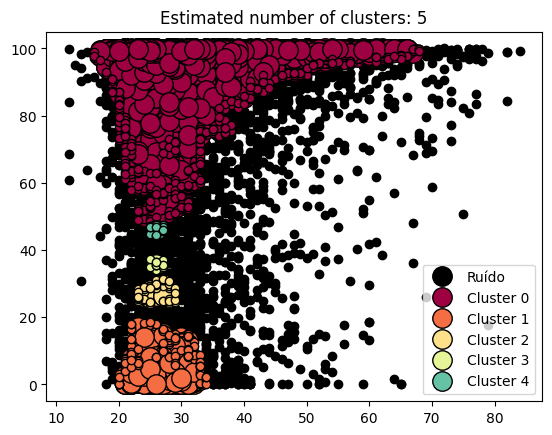

In [214]:
# Plotar um gráfico

labels_unicas = set(db_labels)
cores = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels_unicas))]

# Definindo a legenda
legendas = []

# Definir handles para a legenda
handles = []

# Primeiro, plote os ruídos (-1)
if -1 in labels_unicas:
    ruido_cor = [0, 0, 0, 1]  # Cor preta para ruídos
    pontos_cluster = (db_labels == -1)

    # Seleciona os dados dos ruídos que são pontos centrais
    xy = dados_padronizados.loc[pontos_cluster & pontos_centrais, :]
    p1, = plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(ruido_cor),
                   markeredgecolor='k', markersize=14)
    handles.append(p1)
    legendas.append("Ruído")

    # Seleciona os dados dos ruídos que não são pontos centrais
    xy = dados_padronizados.loc[pontos_cluster & ~pontos_centrais, :]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(ruido_cor),
             markeredgecolor='k', markersize=6)

# Em seguida, plote os clusters
for i, ruido_cor in zip(labels_unicas, cores):
    # Pule os ruídos (-1), já foram plotados
    if i == -1:
        continue

    pontos_cluster = (db_labels == i)
    
    # Seleciona os dados do cluster que são pontos centrais
    xy = dados_padronizados.loc[pontos_cluster & pontos_centrais, :]
    p2, = plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(ruido_cor),
                   markeredgecolor='k', markersize=14)
    handles.append(p2)
    legendas.append(f"Cluster {i}")  # Adiciona o nome do cluster à legenda

    # Seleciona os dados do cluster que não são pontos centrais
    xy = dados_padronizados.loc[pontos_cluster & ~pontos_centrais, :]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(ruido_cor),
             markeredgecolor='k', markersize=6)

# Adiciona a legenda
plt.legend(handles=handles, labels=legendas, loc='lower right')

# Adiciona o título e exibe o gráfico
plt.title(f'Estimated number of clusters: {n_cluster3}')
plt.show()

In [107]:
check(dados.loc[dados['dbscan'] == 0])

,coluna,tipo,únicos,null_soma,media,desvio,minimo,25%,mediana,75%,maximo,moda,frequência_moda
0,id_cliente,object,12887,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,C1123152,2
1,idade_calculada,int64,49,0,30.110043,7.298486,17.0,25.0,29.0,33.0,65.0,31,1353
2,genero,object,2,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,M,9442
3,localizacao,object,1432,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,MUMBAI,1321
4,saldo,float64,11542,0,122578.931881,485141.632008,4.69,8814.9575,23013.62,71261.3225,17772978.13,16609.17,30
5,quantia_transacao (INR),float64,3767,0,1116.314274,3597.774949,0.0,150.0,400.0,1000.0,137890.0,100.0,444
6,genero_codificado,int64,2,0,0.268289,0.443086,0.0,0.0,0.0,1.0,1.0,0,9442
7,saldo_total,float64,12792,0,123695.246155,485759.346224,5.69,9316.23,23790.055,72560.445,17790704.13,1969.04,3
8,porcentagem_tranferida,float64,12791,0,3.919869,5.632222,0.0,0.50271,1.613685,4.7222,32.705818,0.0,9
9,porcentagem_retida,float64,12792,0,96.080131,5.632222,67.294182,95.2778,98.386315,99.49729,100.0,100.0,8


##### 3.1.b.3. Análise por tabela do DBSCAN

In [230]:
import pandas as pd

def gerar_tabela_cluster_completo_dbscan(dados, colunas, dbscan_model):
    """
    Gera uma tabela com as características dos clusters gerados pelo DBSCAN:
    nome do cluster, quantidade de clientes, moda do gênero, faixa etária 
    com base no top 10 modas, maiores localizações e porcentagem de retenção.
    """
    # Adiciona os rótulos de clusters ao DataFrame a partir do modelo DBSCAN
    dados['dbscan'] = dbscan_model.labels_
    
    # Inicializar a tabela
    tabela_cluster_completo = pd.DataFrame(columns=['Cluster', 'Clientes', 'Genero', 'Faixa Etária', 
                                                    'Top 3 Localizações', 'Porcentagem de Retenção'])

    # Iterar sobre os clusters
    for cluster_id in set(dados['dbscan']):
        # Ignorar o cluster de ruído (-1)
        if cluster_id == -1:
            continue
        
        # Filtrar os dados para o cluster atual
        cluster_data = dados[dados['dbscan'] == cluster_id]
        
        # Obter a quantidade de clientes do cluster
        quantidade_clientes = len(cluster_data)
        
        # Moda de gênero
        if not cluster_data['genero'].isnull().all():  # Verifica se há valores não nulos
            genero_moda = cluster_data['genero'].value_counts().idxmax()
            genero_frequencia = cluster_data['genero'].value_counts().max()
            genero_percentual = (genero_frequencia / quantidade_clientes) * 100
            genero_moda_str = f"{genero_moda} ({int(genero_percentual)}%)"
        else:
            genero_moda_str = "Não disponível"
        
        # Faixa etária com base no top 10 modas
        if not cluster_data['idade_calculada'].isnull().all():  # Verifica se há idades não nulas
            top_10_idades = cluster_data['idade_calculada'].value_counts().head(10).index
            idade_minima = min(top_10_idades)
            idade_maxima = max(top_10_idades)
            faixa_etaria_str = f"{idade_minima} a {idade_maxima}"
        else:
            faixa_etaria_str = "Não disponível"
        
        # Top 3 localizações
        if not cluster_data['localizacao'].isnull().all():  # Verifica se há localizações não nulas
            top_localizacoes = cluster_data['localizacao'].value_counts().head(3)
            top_localizacoes_str = ', '.join([f"{local} ({quantidade})" for local, quantidade in top_localizacoes.items()])
        else:
            top_localizacoes_str = "Não disponível"
        
        # Porcentagem de retenção
        if not cluster_data['porcentagem_retida'].isnull().all():  # Verifica se há porcentagens não nulas
            porcentagem_retenção_min = cluster_data['porcentagem_retida'].min()
            porcentagem_retenção_max = cluster_data['porcentagem_retida'].max()
            porcentagem_retenção_str = f"{int(porcentagem_retenção_min)}% a {int(porcentagem_retenção_max)}%"
        else:
            porcentagem_retenção_str = "Não disponível"
        
        # Criar um novo DataFrame para adicionar à tabela
        nova_linha = pd.DataFrame([{
            'Cluster': f'Cluster {cluster_id}',
            'Clientes': quantidade_clientes,
            'Genero': genero_moda_str,
            'Faixa Etária': faixa_etaria_str,
            'Top 3 Localizações': top_localizacoes_str,
            'Porcentagem de Retenção': porcentagem_retenção_str
        }])

        # Concatenar a nova linha com a tabela existente
        tabela_cluster_completo = pd.concat([tabela_cluster_completo, nova_linha], ignore_index=True)
    
    # Exibir a tabela
    print("Tabela de características dos Clusters DBSCAN:\n")
    print(tabela_cluster_completo)

# Exemplo de uso
# A variável 'dados' deve ser o DataFrame contendo as informações e 'dbscan_model' o modelo DBSCAN treinado.
colunas_para_analisar = ['localizacao', 'genero', 'idade_calculada', 'saldo', 'quantia_transacao (INR)']
# Aqui 'dados' e 'dbscan_model' devem ser definidos anteriormente
gerar_tabela_cluster_completo_dbscan(dados, colunas_para_analisar, dbscan)

Tabela de características dos Clusters DBSCAN:

     Cluster Clientes   Genero Faixa Etária  \
0  Cluster 0    13598  M (73%)      22 a 31   
1  Cluster 1      620  M (78%)      22 a 31   
2  Cluster 2       89  M (80%)      23 a 29   
3  Cluster 3       20  M (85%)      25 a 27   
4  Cluster 4       20  M (75%)      25 a 27   

                                  Top 3 Localizações Porcentagem de Retenção  
0  MUMBAI (1377), NEW DELHI (1103), BANGALORE (1066)              48% a 100%  
1            MUMBAI (55), BANGALORE (46), DELHI (40)                0% a 18%  
2               NEW DELHI (8), DELHI (7), MUMBAI (6)               24% a 31%  
3      NEW DELHI (4), BANGALORE (3), NAVI MUMBAI (1)               34% a 37%  
4               NEW DELHI (5), DELHI (2), MUMBAI (2)               44% a 47%  


### 3.2. Com os resultados em mão, descreva o processo de mensuração do índice de silhueta. Mostre o gráfico e justifique o número de clusters escolhidos.

Resposta:

O índice de silhueta é uma métrica utilizada para avaliar a qualidade de um agrupamento. Ele mede o quão bem um determinado ponto está atribuído ao seu cluster em comparação com outros clusters, refletindo tanto a coesão dentro do cluster (medida interna) quanto a separação entre clusters (medida externa).

A coesão mede a distância média de um ponto para todos os pontos no mesmo cluster.

A separação mede a distância média de um ponto para todos os pontos do cluster mais próximo, diferente do cluster ao qual ele pertence.

O índice da silhueta considera a fórmula: separação - coesão

Dessa forma:

- Se a separação for **maior** que a coesão, o resultado do índice da silhueta será positivo, indicando uma **boa distribuição** dos clusters;
- Se a separação for **parecida** com a coesão, o resultado do índice da silhueta será próximo a zero, indicando que **os dados estão no limitrofe** dos clusters;
- Se a separação for **menor** que a coesão, o resultado do índice da silhueta será negativo, indicando uma **má distribuição** dos clusters.

Por fim, o índice de silhueta médio, calcula a média dos valores de cada cluster, seguindo a mesma ideia de avaliação (<0, =0 e >0).

#### 3.2.1. Gráficos do índice da silhueta para o K-Means

Para o K-Means, foi escolhido k=6, pois é um número onde o índice de silhueta apresenta poucos negativos e um bom resultado (0,43)

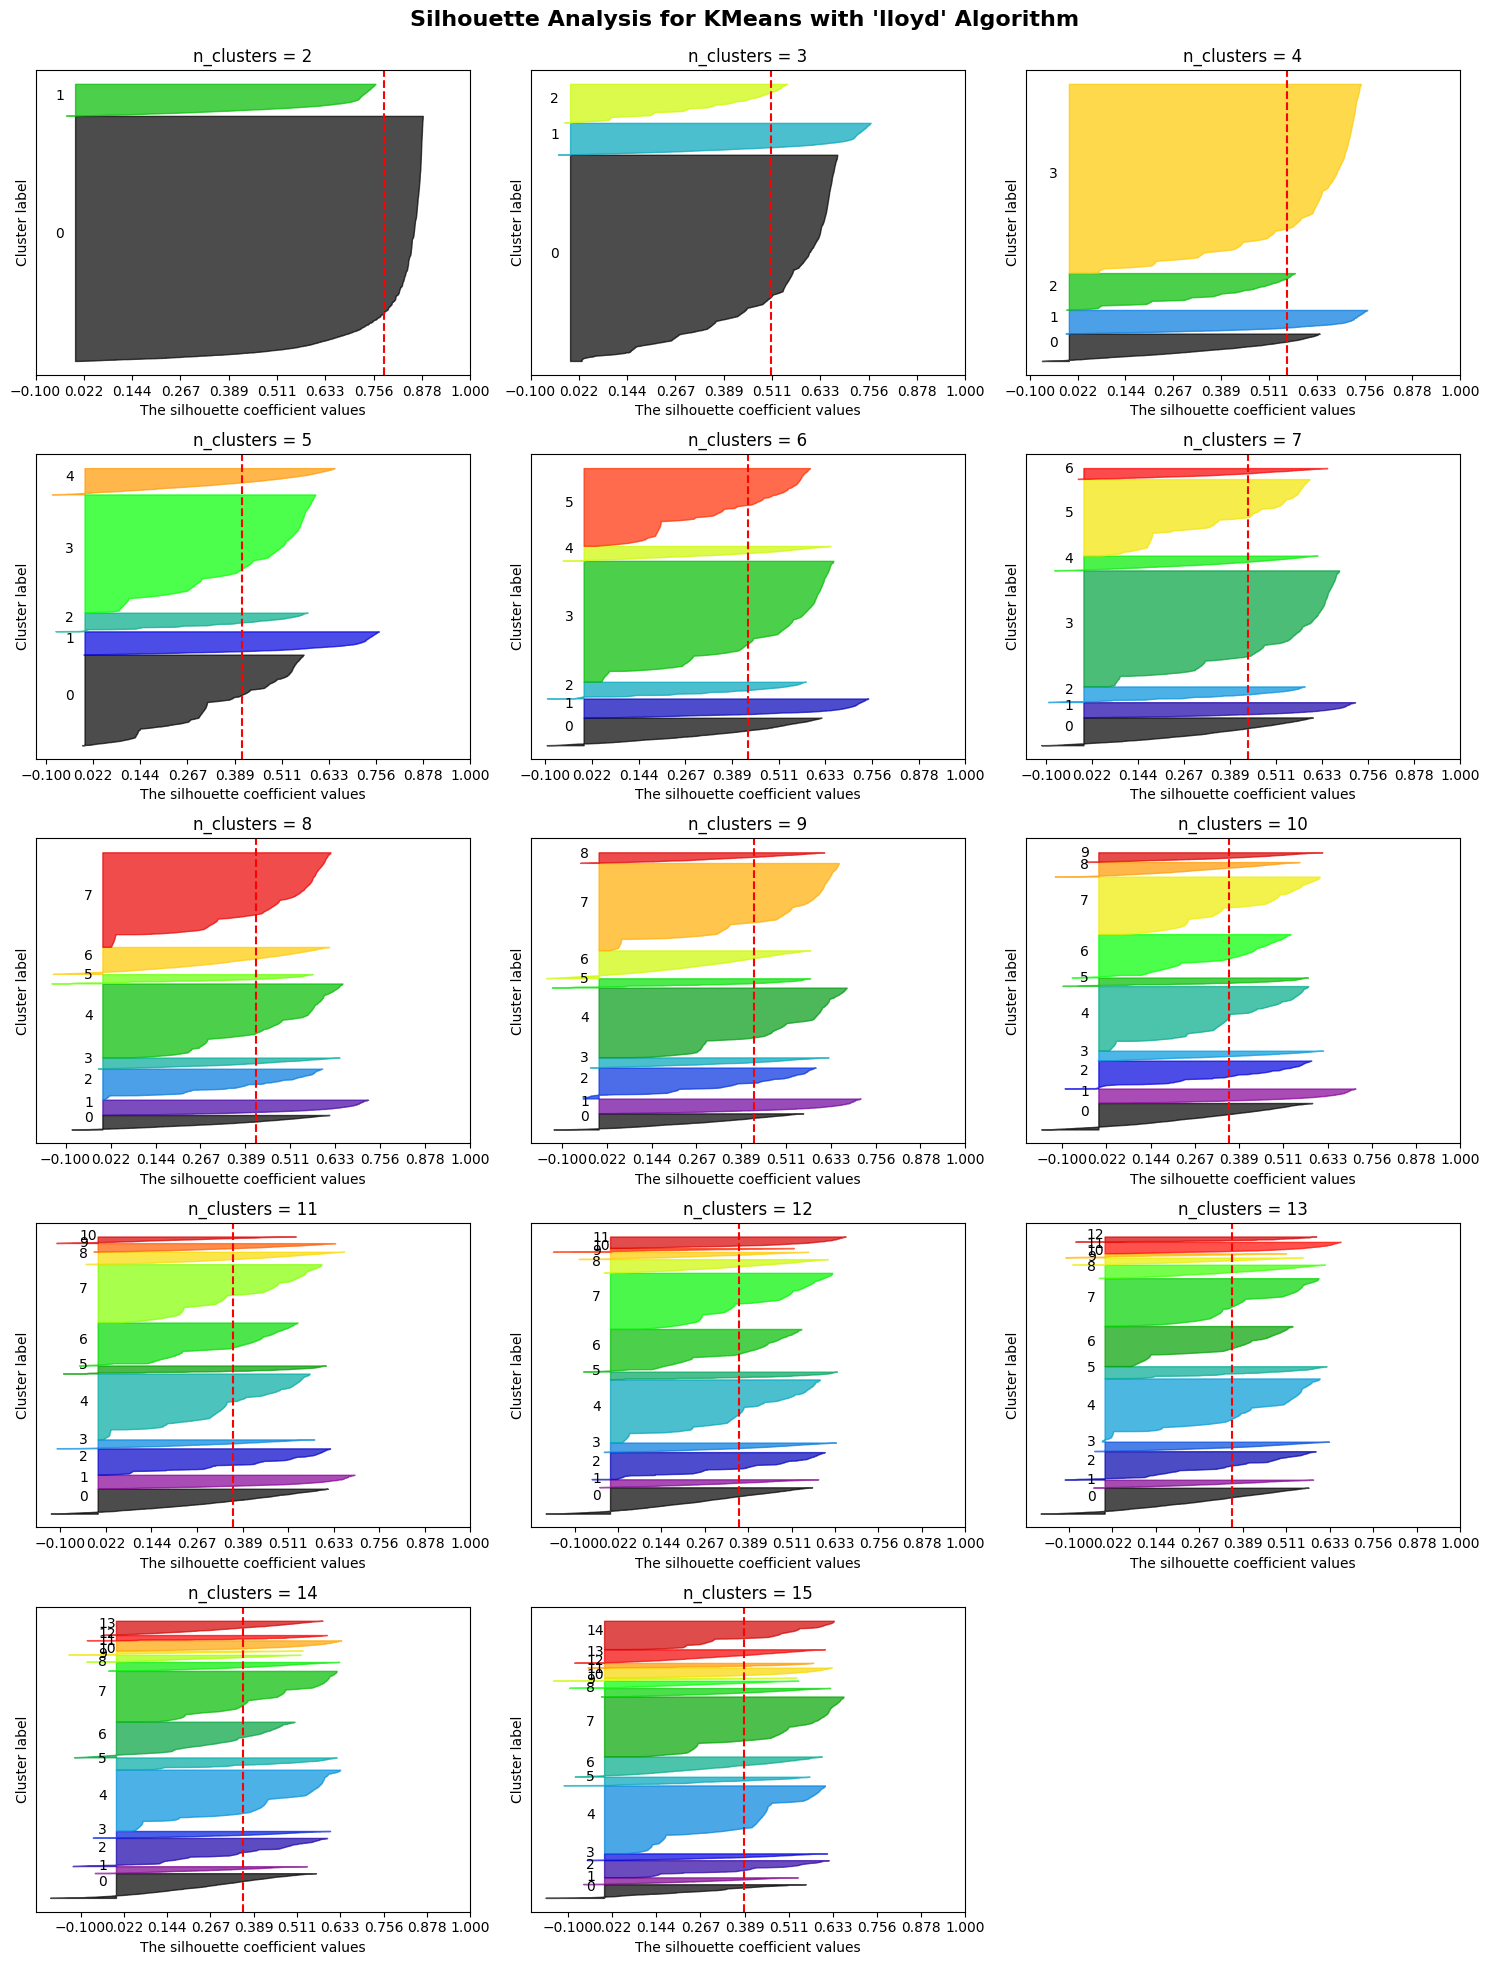

Resultados de Silhueta por valor de k:
k = 2, Silhouette Score = 0.7817589775693542
k = 3, Silhouette Score = 0.5095833962082391
k = 4, Silhouette Score = 0.5566375554725426
k = 5, Silhouette Score = 0.4086728182205524
k = 6, Silhouette Score = 0.43156010454571886
k = 7, Silhouette Score = 0.43583187991255534
k = 8, Silhouette Score = 0.4184735193538283
k = 9, Silhouette Score = 0.4235972556282004
k = 10, Silhouette Score = 0.3608025084980713
k = 11, Silhouette Score = 0.3639881754477091
k = 12, Silhouette Score = 0.3629703103321492
k = 13, Silhouette Score = 0.35751200299676444
k = 14, Silhouette Score = 0.3598170469199731
k = 15, Silhouette Score = 0.38825982694567235


In [89]:
# Configuração inicial
teste_numero = 1
melhor_valor = -1
melhor_teste = -1

# Lista para armazenar os resultados de k e score
resultados_silhueta = []

# Filtrando resultados apenas para o algoritmo 'lloyd'
k_values = range(2, 16)

# Criando subplots para cada valor de k
num_plots = len(k_values)
cols = 3  # Número de colunas na grid
rows = (num_plots + cols - 1) // cols  # Calculando o número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
fig.suptitle("Silhouette Analysis for KMeans with 'lloyd' Algorithm", fontsize=16, fontweight='bold')

# Flattening axes to make it iterable
axes = axes.flatten()

# Loop através de cada valor de k
for idx, (ax, k) in enumerate(zip(axes, k_values)):
    kmeans = KMeans(
                    n_clusters=k,
                    algorithm='lloyd',
                    init="k-means++",
                    max_iter=300,
                    tol=0.0001,
                    random_state=10,
                    n_init="auto"
                    )
    
    labels = kmeans.fit_predict(dados_padronizados)
    silhouette_avg = silhouette_score(dados_padronizados, labels)
    sample_silhouette_values = silhouette_samples(dados_padronizados, labels)
    
    # Armazenando o valor de k e o score
    resultados_silhueta.append((k, silhouette_avg))
    
    y_lower = 10
    
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f"n_clusters = {k}")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks(np.linspace(-0.1, 1, 10))

# Escondendo qualquer eixo vazio
for i in range(num_plots, len(axes)):
    axes[i].axis('off')

# Ajustando o layout e a posição do título
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Reduzindo o espaço entre o título e os gráficos
plt.show()

# Exibindo os resultados armazenados (k e seu respectivo score)
print("Resultados de Silhueta por valor de k:")
for k, score in resultados_silhueta:
    print(f"k = {k}, Silhouette Score = {score}")

C:\Users\Mateus\AppData\Local\Temp\ipykernel_181480\176291775.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', linewidth=1, label='Silhouette Score')


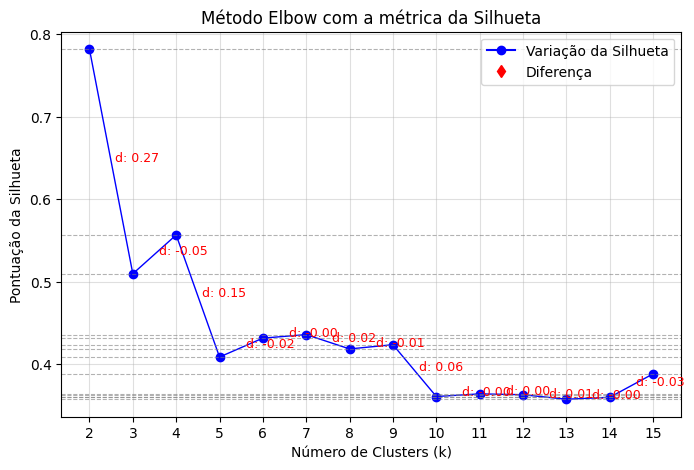

In [95]:
# Extrair os valores de k e silhouette_score a partir de resultados_silhueta
silhouette_scores = [score for k, score in resultados_silhueta]
k_values = [k for k, score in resultados_silhueta]

# Calculando as diferenças entre os scores
distancias = [silhouette_scores[i] - silhouette_scores[i + 1] for i in range(len(silhouette_scores) - 1)]

# Plotando os resultados
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, 'bo-', color='blue', linewidth=1, label='Silhouette Score')

# Adiciona linhas horizontais pontilhadas para cada ponto
for i, y in enumerate(silhouette_scores):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

# Exibe as distâncias no gráfico
for i, (k, dist) in enumerate(zip(k_values[:-1], distancias)):
    midpoint = (silhouette_scores[i] + silhouette_scores[i + 1]) / 2
    plt.text(k + 0.6, midpoint, f"d: {dist:.2f}", color='red', fontsize=9)

# Configurações do gráfico
plt.title('Método Elbow com a métrica da Silhueta')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Pontuação da Silhueta')
plt.xticks(k_values)
plt.grid(True, alpha=0.4)

# Legenda
custom_legend = [
    Line2D([0], [0], color='blue', marker='o', linestyle='-', label='Variação da Silhueta'),
    Line2D([0], [0], color='red', marker='d', linestyle='', label='Diferença'),
]
plt.legend(handles=custom_legend, loc='upper right')

plt.show()

#### 3.2.2. Gráficos do índice da silhueta para o DBSCAN

Para o DBSCAN foram realizadas diversas buscas de silhueta para encontrar o melhor intervalo possível.

Num primeiro momento foi feito o seguinte intervalo: ‘eps’ de 0,8 a 1,8 e ‘samples’ de 10 a 100 (de 10 em 10).

A partir disso, fora realizada uma nova busca, dessa vez com ‘eps’ de 1,2 a 1,8 e ‘samples’ de 20 a 70 (de 5 em 5).

A terceira busca, fora realizada com ‘eps’ de 1,2 a 1,8 e ‘samples’ de 22 a 46 (de 2 em 2).

In [193]:
def avaliar_dbscan(dados_padronizados, eps_range, samples_range):
    """
    Avalia combinações de parâmetros para DBSCAN, armazena os resultados e exibe os 10 melhores.

    Parâmetros:
        dados_padronizados (array-like): Dados padronizados para clustering.
        eps_range (iterable): Intervalo de valores para o parâmetro `eps`.
        samples_range (iterable): Intervalo de valores para o parâmetro `min_samples`.

    Retorno:
        list: Os 10 melhores resultados ordenados por `silhouette_score`.
    """
    global resultados_dbscan  # Para preservar os resultados entre chamadas

    for eps in eps_range:
        for min_samples in samples_range:
            # Criando o modelo DBSCAN
            dbscan = DBSCAN(eps=float(eps), min_samples=int(min_samples))  # Garantir tipos corretos
            labels = dbscan.fit_predict(dados_padronizados)
            
            # Contando clusters válidos
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if num_clusters > 1:
                silhouette_avg = silhouette_score(dados_padronizados, labels)
                resultados_dbscan.append((float(eps), int(min_samples), silhouette_avg, num_clusters))

    # Remover duplicatas: Criar um conjunto para garantir unicidade e depois converter de volta para lista
    resultados_unicos = list(set(resultados_dbscan))

    # Ordenar os resultados por score em ordem decrescente
    resultados_ordenados = sorted(resultados_unicos, key=lambda x: x[2], reverse=True)

    # Selecionar os 10 melhores resultados
    melhores_resultados = resultados_ordenados[:10]

    # Exibir os 10 melhores resultados
    print("As 10 melhores pontuações foram:")
    print(f"{'eps':<10} {'samples':<10} {'score':<10} {'clusters':<10}")

    for eps, samples, score, num_clusters in melhores_resultados:
        print(f"{eps:<10.2f} {samples:<10} {score:<10.6f} {num_clusters:<10}")

Primeiro teste

In [194]:
eps_range = np.arange(0.8, 1.8, 0.1)
samples_range = np.arange(10, 100, 10)

avaliar_dbscan(dados_padronizados, eps_range, samples_range)

As 10 melhores pontuações foram:
eps        samples    score      clusters  
1.60       30         0.595409   4         
1.50       40         0.586906   3         
1.20       30         0.575628   3         
1.40       40         0.573572   3         
1.70       20         0.569989   5         
1.60       20         0.559152   6         
1.60       60         0.514704   2         
1.50       60         0.506376   2         
1.40       60         0.498059   2         
1.40       10         0.488330   16        


Fine tuning 1

In [195]:
eps_range = np.arange(1.2, 1.8, 0.1)
samples_range = np.arange(20, 70, 5)

avaliar_dbscan(dados_padronizados, eps_range, samples_range)

As 10 melhores pontuações foram:
eps        samples    score      clusters  
1.80       35         0.633910   2         
1.60       30         0.595409   4         
1.60       30         0.595409   4         
1.80       20         0.595180   5         
1.70       45         0.588857   4         
1.50       40         0.586906   3         
1.50       40         0.586906   3         
1.60       45         0.584076   3         
1.20       30         0.575628   3         
1.40       40         0.573572   3         


Fine tuning 2

In [197]:
eps_range = np.arange(1.2, 1.8, 0.1)
samples_range = np.arange(22, 46, 2)

avaliar_dbscan(dados_padronizados, eps_range, samples_range)

As 10 melhores pontuações foram:
eps        samples    score      clusters  
1.80       35         0.633910   2         
1.80       36         0.633078   2         
1.70       34         0.629957   2         
1.80       38         0.628957   2         
1.80       34         0.602747   3         
1.70       44         0.597703   3         
1.60       32         0.596270   3         
1.60       30         0.595409   4         
1.60       30         0.595409   4         
1.80       20         0.595180   5         


Plotando gráficos

Elbow com a métrica de silhueta

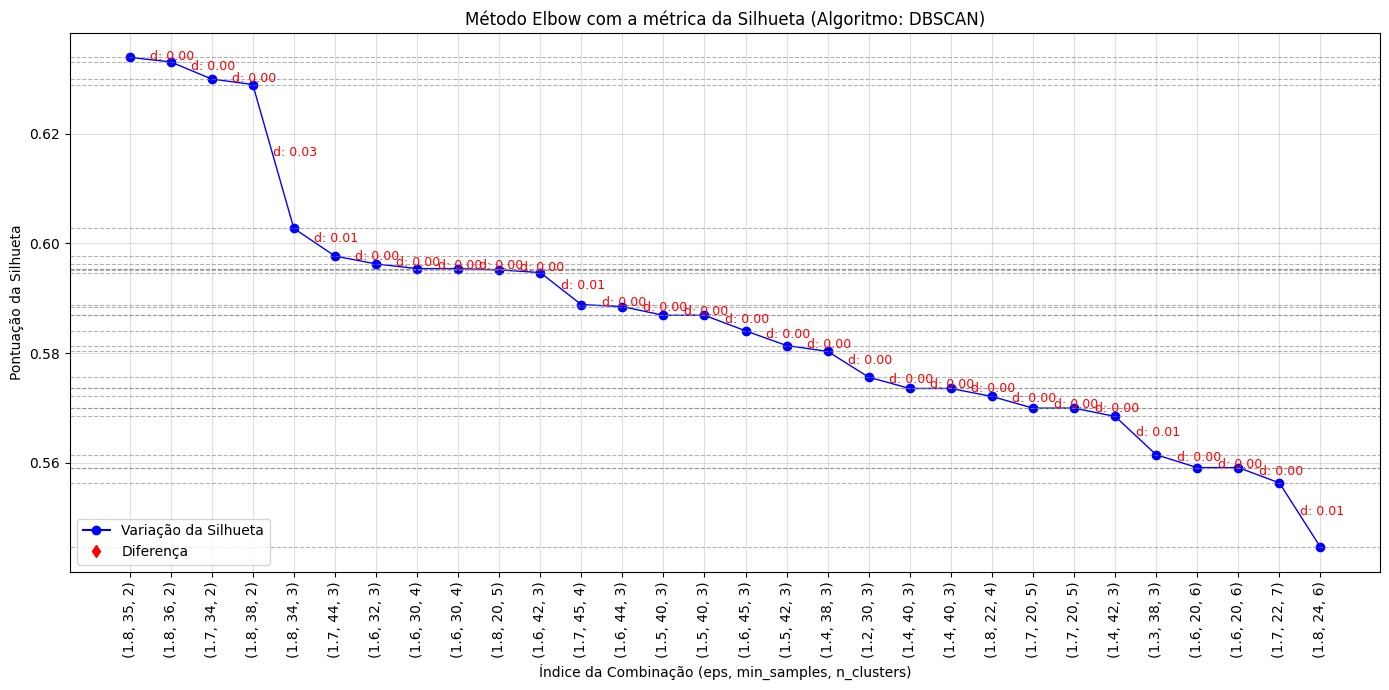

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Remover duplicatas e ordenar os resultados por silhouette_score de forma decrescente
resultados_unicos = list(set(resultados_dbscan))
resultados_ordenados = sorted(resultados_unicos, key=lambda x: x[2], reverse=True)

# Selecionar os primeiros 30 melhores resultados
melhores_resultados = resultados_ordenados[:30]

# Extrair os valores de eps, min_samples, silhouette_score e n_clusters
silhouette_scores = [score for eps, min_samples, score, clusters in melhores_resultados]
eps_values = [round(eps, 2) for eps, min_samples, score, clusters in melhores_resultados]
min_samples_values = [min_samples for eps, min_samples, score, clusters in melhores_resultados]
n_clusters_values = [clusters for eps, min_samples, score, clusters in melhores_resultados]

# Calculando as diferenças entre os scores
distancias = [silhouette_scores[i] - silhouette_scores[i + 1] for i in range(len(silhouette_scores) - 1)]

# Plotando os resultados
plt.figure(figsize=(14, 7))
plt.plot(range(len(silhouette_scores)), silhouette_scores, 'bo-', linewidth=1, label='Silhouette Score')

# Adiciona linhas horizontais pontilhadas para cada ponto
for i, y in enumerate(silhouette_scores):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

# Exibe as distâncias no gráfico
for i, dist in enumerate(distancias):
    midpoint = (silhouette_scores[i] + silhouette_scores[i + 1]) / 2
    plt.text(i + 0.5, midpoint, f"d: {dist:.2f}", color='red', fontsize=9)

# Configurações do gráfico
plt.title('Método Elbow com a métrica da Silhueta (Algoritmo: DBSCAN)')
plt.xlabel('Índice da Combinação (eps, min_samples, n_clusters)')
plt.ylabel('Pontuação da Silhueta')

# Modificando as labels do eixo x para o formato (eps, samples, clusters)
plt.xticks(range(len(silhouette_scores)), [f"({eps}, {samples}, {clusters})" for eps, samples, clusters in zip(eps_values, min_samples_values, n_clusters_values)], rotation=90)
plt.grid(True, alpha=0.4)

# Legenda
custom_legend = [
    Line2D([0], [0], color='blue', marker='o', linestyle='-', label='Variação da Silhueta'),
    Line2D([0], [0], color='red', marker='d', linestyle='', label='Diferença')
]
plt.legend(handles=custom_legend, loc='best')

plt.tight_layout()
plt.show()

Gráfico de silhueta

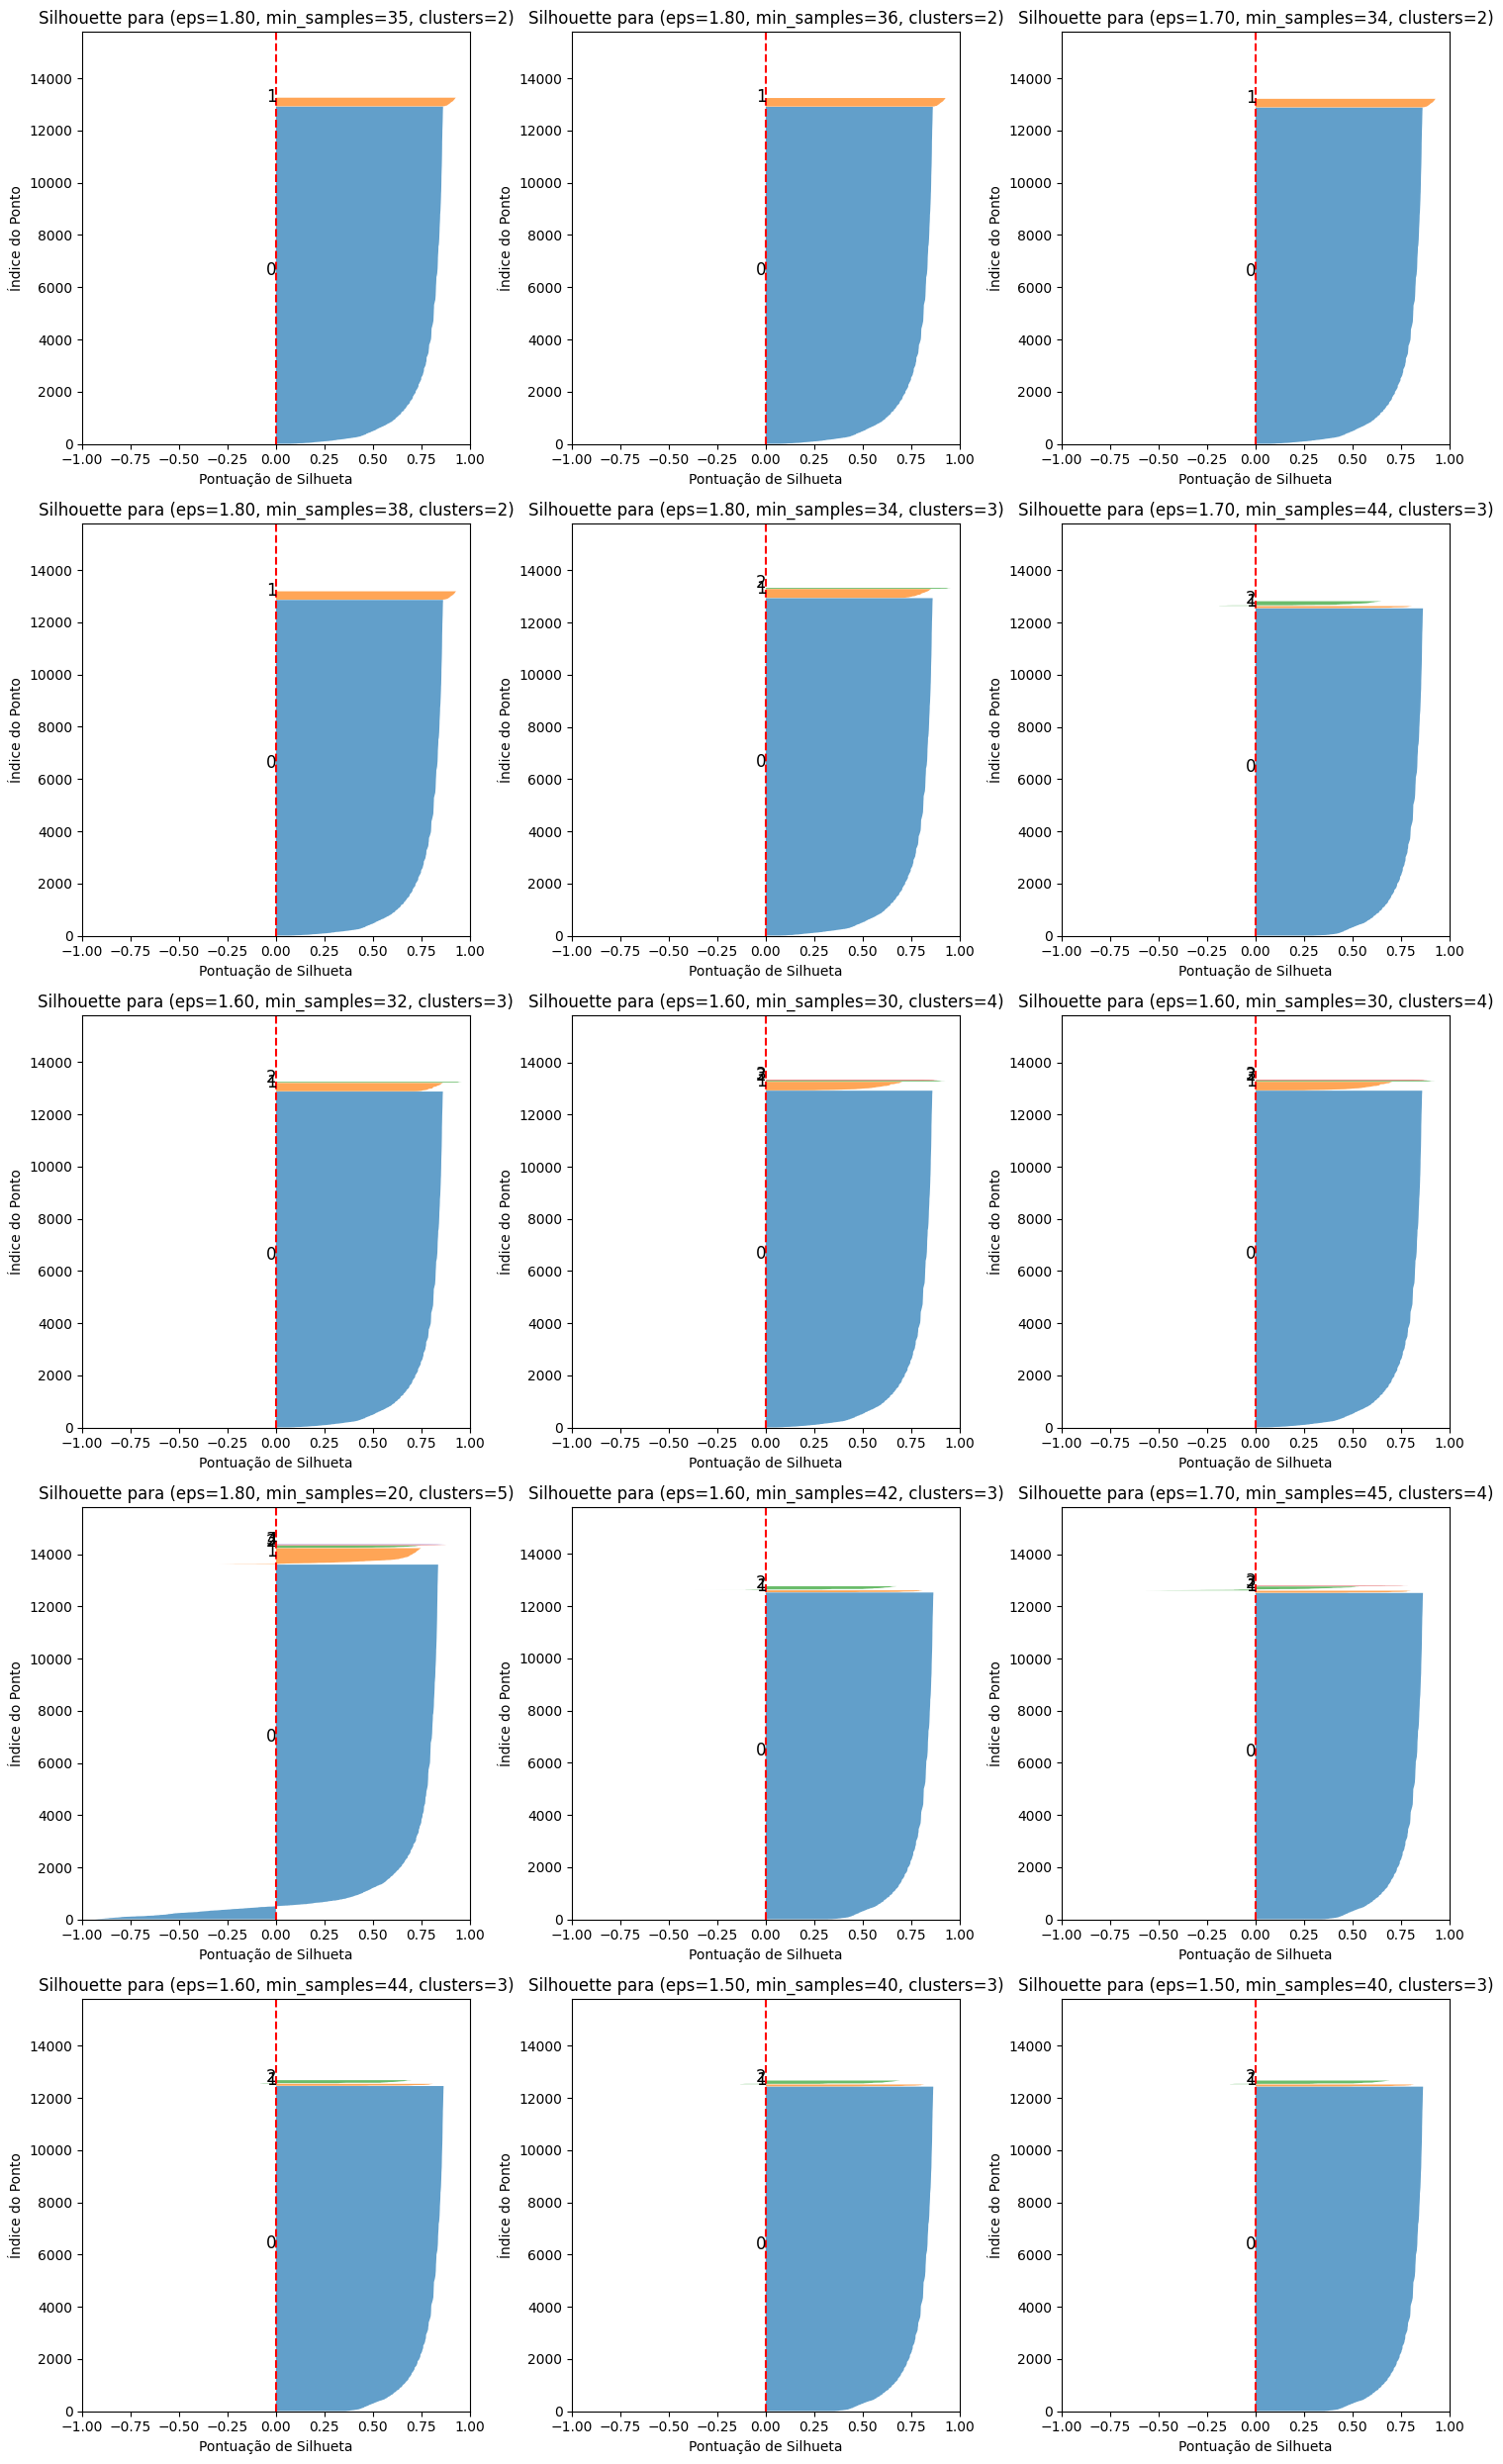

In [204]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
import numpy as np

# Remover duplicatas e ordenar os resultados por silhouette_score de forma decrescente
resultados_unicos = list(set(resultados_dbscan))
resultados_ordenados = sorted(resultados_unicos, key=lambda x: x[2], reverse=True)

# Selecionar as 15 melhores combinações
melhores_resultados = resultados_ordenados[:15]

# Preparar o gráfico (grid de 3 colunas e 5 linhas)
fig, axes = plt.subplots(5, 3, figsize=(15, 25))

# Listas para extrair os valores necessários
eps_values = [round(eps, 2) for eps, min_samples, score, clusters in melhores_resultados]
min_samples_values = [min_samples for eps, min_samples, score, clusters in melhores_resultados]
n_clusters_values = [clusters for eps, min_samples, score, clusters in melhores_resultados]
silhouette_scores = [score for eps, min_samples, score, clusters in melhores_resultados]

# Iterar sobre os melhores resultados e gerar os gráficos de silhueta
for i, (eps, min_samples, score, clusters) in enumerate(melhores_resultados):
    # Extrair os dados de clustering
    dbscan = DBSCAN(eps=float(eps), min_samples=int(min_samples))
    labels = dbscan.fit_predict(dados_padronizados)

    # Calcular a silhueta para cada ponto
    silhouette_vals = silhouette_samples(dados_padronizados, labels)

    # Encontrar o gráfico correspondente (3 colunas por 5 linhas)
    ax = axes[i // 3, i % 3]
    
    # Gerar o gráfico de silhueta
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, len(dados_padronizados) + (len(set(labels)) + 1) * 10])
    ax.set_title(f"Silhouette para (eps={eps:.2f}, min_samples={min_samples}, clusters={clusters})")

    ax.axvline(x=0, color="red", linestyle="--")
    ax.set_xlabel("Pontuação de Silhueta")
    ax.set_ylabel("Índice do Ponto")
    
    # Plotar os valores da silhueta para cada ponto
    y_lower, y_upper = 10, 10
    for i_cluster in range(len(set(labels)) - (1 if -1 in labels else 0)):
        cluster_silhouette_vals = silhouette_vals[labels == i_cluster]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + len(cluster_silhouette_vals)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        ax.text(-0.05, (y_lower + y_upper) / 2, str(i_cluster), color='black', fontsize=12)
        y_lower = y_upper + 10

# Ajuste do layout
plt.tight_layout()
plt.show()

### 3.3. Compare os dois resultados, aponte as semelhanças e diferenças e interprete.

Resposta:

Como primeira análise, percebe-se que o DBSCAN, em razão de necessitar de dois hiperparâmetros (‘eps’ e ‘min_samples’), possui um intervalo de pesquisa bem maior do score de silhueta.

Além disso, o DBSCAN agrupa os ruídos (noises) como ‘-1’, fazendo com que tenhamos que tratar esse grupo, limitando a comparação entre os modelos, visto que não é eficaz comparar um grupo do K-Means com ruídos do DBSCAN porque os ruídos estão espalhados por todos os grupos do K-Means, conforme já analisado.

Ao analisar o índice de acurácia, temos uma similaridade de cerca de 11% entre os modelos.

Ambos os algoritmos podem gerar valores de silhueta positivos quando o agrupamento for bem feito. Se os clusters são bem definidos e os pontos estão bem agrupados, ambos os algoritmos devem exibir um bom resultado de silhueta.

Em razão da necessidade de escolhas de hiperparâmetros, (‘k ’ para o K-Means; e ‘eps’ e ‘min_samples’ para o DBSCAN). A escolha errada pode levar a uma pontuação de silhueta ruim.

Caso o dataset possua outliers, o DBSCAN pode resultar em uma pontuação de silhueta mais alta, pois esses são identificados e excluídos do cálculo. Já o K-Means, sendo sensível a outliers, pode reduzir a pontuação de silhueta se houver muitos pontos distantes do centroide.

O K-Means ainda tende a formar clusters esféricos, o que pode não ser adequado se os dados tiverem clusters de formas irregulares. Já o DBSCAN, por ser um algoritmo baseado em densidade, é mais flexível e pode capturar clusters de formas mais complexas.

Como os resultados de score da silhueta foram positivos (cerca de 0,43 para o K-Means e 0,59 para o DBSCAN), podemos dizer que, embora os dados estejam bem densos, também estão bem distribuídos nos parâmetros propostos. Em geral, pode-se dizer que a comparação entre K-Means e DBSCAN em termos de silhueta depende muito das características dos dados.

In [218]:
# Remover os outliers (valores -1) de 'dbscan' e garantir que os índices sejam correspondentes
dbscan_cleaned = dados['dbscan'][dados['dbscan'] != -1]
clusters_cleaned = dados['clusters'][dados['dbscan'] != -1]

# Agora, podemos calcular a acurácia
accuracy = metrics.accuracy_score(clusters_cleaned, dbscan_cleaned)

print("Acurácia entre K-Means e DBSCAN:", accuracy)

Acurácia entre K-Means e DBSCAN: 0.11005785181571061


### 3.4. Escolha mais duas medidas de validação para comparar com o índice de silhueta e analise os resultados encontrados. Observe, para a escolha, medidas adequadas aos algoritmos.

Resposta:

Foram escolhidas as métricas de ‘Davies-Bouldin’ e ‘Calinski-Harabasz’.

O Índice de Davies-Bouldin mede a qualidade do agrupamento com base na relação entre a coesão e a separação dos clusters.

Já o Índice de Calinski-Harabasz, também conhecido como Índice de Variância entre e dentro dos clusters, mede a separação global dos clusters em comparação com a compactação interna.

Vale dizer que ambos os índices são compatíveis com o K-Means e o DBSCAN.

In [221]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Função auxiliar para calcular as métricas
def calcular_metricas(dados2, labels, model_name):
    """
    Calcula as métricas de validação: Silhueta, Davies-Bouldin e Calinski-Harabasz.
    Ignora rótulos -1 (outliers) se existirem.
    """
    filtro = labels != -1  # Filtrar outliers para DBSCAN
    
    # Calcular as métricas, ignorando outliers (-1)
    silhouette = silhouette_score(dados2[filtro], labels[filtro]) if len(set(labels[filtro])) > 1 else None
    davies = davies_bouldin_score(dados2[filtro], labels[filtro]) if len(set(labels[filtro])) > 1 else None
    calinski = calinski_harabasz_score(dados2[filtro], labels[filtro]) if len(set(labels[filtro])) > 1 else None
    
    return {
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies,
        'Calinski-Harabasz Index': calinski
    }

# Dicionário para armazenar os resultados
resultados_validacao = {}

# --- 1. KMeans ---
kmeans_labels = kmeans.fit_predict(dados_padronizados)  # Usando dados_padronizados
resultados_validacao['KMeans'] = calcular_metricas(dados_padronizados, kmeans_labels, 'KMeans')

# --- 2. DBSCAN ---
dbscan_labels = dbscan.fit_predict(dados_padronizados)  # Usando dados_padronizados
resultados_validacao['DBSCAN'] = calcular_metricas(dados_padronizados, dbscan_labels, 'DBSCAN')

# Exibindo os resultados em um DataFrame
resultado_final = pd.DataFrame(resultados_validacao).T
print("Comparação das Medidas")
print(resultado_final)

Comparação das Medidas
        Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
KMeans          0.388260              0.838755             36844.581287
DBSCAN          0.709336              0.313788             10393.253757


### 3.5. Realizando a análise, responda: A silhueta é um o índice indicado para escolher o número de clusters para o algoritmo de DBSCAN?

Resposta:

Se os dados estiverem bem dispostos e o cluster de ruído for isolado, é possível utilizar o índice de silhueta para escolher os hiperparâmetros necessários (‘eps’ e ‘min_samples’), avaliar a qualidade de clusterização e ainda para se chegar ao melhor número de clusters do DBSCAN.

## Parte 4. Medidas de similaridade

---

<a href='#índice'>Voltar ao início</a>

### 4.1. Um determinado problema, apresenta 10 séries temporais distintas. Gostaríamos de agrupá-las em 3 grupos, de acordo com um critério de similaridade, baseado no valor máximo de correlação cruzada entre elas. Descreva em tópicos todos os passos necessários.

Resposta:

Para realizar o agrupamento de séries temporais, reduzindo a sua dimensionalidade, em primeiro lugar, devemos realizar a preparação correta dos dados. Garantir que todas as séries temporais estão no formato correto para a análise, sem dados nulos ou repetidos. 

Além disso, caso possuam escalas diferentes, deve-se realizar a normalização de seus dados, para evitar magnitudes diferentes que afetem os resultados da correlação.

Em segundo lugar, deve-se calcular a correlação cruzada, que mede a similaridade entre duas séries temporais, para isso pode-se utilizar o ‘numpy.correlate’ ou ‘scipy.signal_correlate’, onde para cada par, deve registrar o número máximo da correlação cruzada, sendo pois, o critério de similaridade.

A partir disso, é possível criar uma matriz de similaridade, utilizando gráficos como o heatmap, por exemplo.

E daí, enfim, agrupar os dados resultantes nos três clusters desejados.

### 4.2. Para o problema da questão anterior, indique qual algoritmo de clusterização você usaria. Justifique.

Resposta:

Para agrupar dados baseados em uma matriz de similaridade, é recomendável o modelo de agrupamento hierárquico (HCluster), utilizando o dendrograma como ferramenta de visualização. 

Isso porque o agrupamento hierárquico cria uma estrutura de árvore, permitindo visualizar todos os níveis de similaridade entre as séries, através das distâncias de suas folhas.

Além disso, o algoritmo hierárquico funciona diretamente com matrizes, como a de correlação cruzada, proposta aqui.

### 4.3. Indique um caso de uso para essa solução projetada.

Resposta:

Um caso de uso prático para essa solução projetada seria na análise de comportamento de consumidores em diferentes períodos, especialmente em setores como o varejo ou o financeiro.

No caso proposto em tela, "uma loja online deseja analisar os padrões de 10 clientes ao longo de um ano, onde cada cliente possui uma série temporal que representa o número de compras feitas no mês".

A clusterização poderia possibilitar traçar perfis de clientes, de acordo com seus padrões de compra.

### 4.4. Sugira outra estratégia para medir a similaridade entre séries temporais. Descreva em tópicos os passos necessários.

Resposta:

Uma outra estratégia para medir a similaridade entre séries temporais é a utilização da distância Dynamic Time Warping (DTW).

Essa técnica é particularmente útil quando as séries temporais podem ter defasagens ou variações de amplitude, mas ainda assim têm padrões semelhantes. 

Para isso, os passos necessários seriam:

- Realizar o pré-processamento das séries temporais conforme já tratado nas perguntas anteriores;

- Calcular a distância de DTW, de forma a medir a distância entre duas séries temporais, tentando “alinhar” os pontos das séries de maneira não linear, minimizando a diferença entre elas;

- Construir a matriz de similaridade, onda cada célula contém o valor da distância entre a série ‘a’ e a série ‘b’;

- Realizar a clusterização utilizando o agrupamento hierárquico, conforme já tratado nas perguntas anteriores.